# Redes Adversativas

Una red adversativa está formado por dos redes que se entrenan simultáneamente intentando ganarse mutuamente. Por un lado tenemos el *generador*, una red como el decoder de un AE que se encarga de crear imágenes nuevas a partir de vectores extraídos del espacio latente. Por otro, está el *discriminador*, una red que debería ser capaz de diferenciar si la imagen o no del input está creada por el generador o si es una imagen real de la base de datos.

El objetivo de una GAN es entrenar el *generador* de tal forma que el discriminador no sea capaz de diferenciar las imágenes porque las imágenes generadas son de muy buena calidad e imitan a la perfección las reales.

In [1]:
import tensorflow as tf
import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()

In [4]:
Xtrain = Xtrain/255
Xtest = Xtest/255

Xtrain = np.expand_dims(Xtrain, -1)
Xtest = np.expand_dims(Xtest,-1)

Xtrain.shape, Xtest.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
Xtrain[0].shape

(28, 28, 1)

In [20]:
discriminador = tf.keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = "relu", padding = "same" ,input_shape = Xtrain[0].shape),
    layers.MaxPool2D(2),
    layers.Conv2D(64, (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(1, activation  = "sigmoid")
])

In [21]:
generador = tf.keras.models.Sequential([
    layers.Dense(7*7*1, activation = "relu", input_shape = (100,)),
    layers.Reshape((7,7,1)),
    layers.Conv2DTranspose(64, (3,3), strides = 2, padding = "same", activation = "relu"),
    layers.Conv2DTranspose(128, (3,3), strides = 2, padding = "same", activation = "relu"),
    layers.Conv2D(1, (3,3), strides = 1, padding = "same", activation = "relu")
])

In [18]:
class GAN(tf.keras.Model):
    def __init__(self, discriminador, generador):
        super(GAN, self).__init__()
        self.discriminador = discriminador
        self.generador = generador
    
    def train_step(self, X):

        ## Generar valores aleatorios

        ruido = tf.random.normal((X.shape[0], 100))

        ## Generar imágen sintética

        generadas = self.generador(ruido)

        ## Pasar las imágenes y entrenar el discriminador
        # Pasar las imágenes reales
        etiquetas_bien = tf.ones((X.shape[0],1))

        with tf.GradientTape() as tape:
            pred_bien = self.discriminador(X)
            error = tf.keras.metrics.binary_crossentropy(etiquetas_bien, pred_bien)

        gradients = tape.gradient(error, self.discriminador.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.discriminador.trainable_variables))


        # Pasar las imágenes reales
        etiquetas_mal = tf.zeros((X.shape[0],1))

        with tf.GradientTape() as tape:
            pred_mal = self.discriminador(generadas)
            error = tf.keras.metrics.binary_crossentropy(etiquetas_mal, pred_mal)
        
        gradients = tape.gradient(error, self.discriminador.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.discriminador.trainable_variables))

        ## Entrenar el generador
        # Generar valores aleatorios
        ruido = tf.random.normal((X.shape[0], 100))

        # Entrenamiento
        etiquetas_bien = tf.ones((X.shape[0],1))
        with tf.GradientTape() as tape:
            # Generar imágen sintética
            generadas = self.generador(ruido)
            # Propagación
            pred_bien = self.discriminador(generadas)
            error = tf.keras.metrics.binary_crossentropy(etiquetas_bien, pred_bien)

        gradients = tape.gradient(error, self.generador.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.generador.trainable_variables))

        return {"Error Generador":error}

In [ ]:
gan = GAN(discriminador=discriminador, generador=generador)
gan.compile(optimizer="adam")
history = gan.fit(Xtrain, epochs=10)

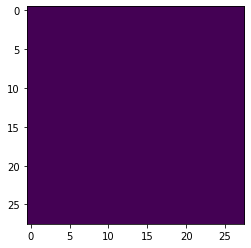

In [30]:
## Generar valores aleatorios

ruido = tf.random.normal((1, 100))

## Generar imágen sintética

generadas = generador(ruido)

plt.figure()
plt.imshow(generadas.numpy().squeeze())
plt.show()